In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager

from IPython.core.pylabtools import figsize
from jupyter_server.transutils import base_dir

from utils.data_filter import filter_tracks,filter_tracks_by_movement, filter_rows_nonzero_velocity, filter_tracks_that_jump, clean_frames_low_detections
from utils.data_utils import load_and_merge_event_data, compute_mean_median_per_frame, extract_frame_time_table, load_piv_data, merge_piv_and_tracking, compute_track_velocities
from utils.plot_utils import plot_variable_against_frame, prepare_df_for_plot, plot_xy_mov_tracks, plot_piv_and_tracking_velocity, plot_track_velocities_mova_per_frame

# Event Details

In [4]:
event_year = "2024"
event_month = "06"
event_day = "14"

event = f"{event_year}_{event_month}_{event_day}"

# Output path
output_dir = Path.cwd() / "output" / event
output_dir.mkdir(parents=True, exist_ok=True)

# Load raw Dataframe
df_raw = load_and_merge_event_data(event)

# create time dataframe for plotting
df_time = extract_frame_time_table(df_raw)

# Define Parameters

In [ ]:
#df = df_raw[df_raw['frame'].between(10000, 15000)]

In [6]:
# Choose Frame range to analyse
start_frame = 0
end_frame = 100000

# Define track lengths
min_track_length = 5
max_track_length = 300

# Velocity limits
max_std_track_vel = 1.5
min_median_track_vel = 0.1

# Jumping threshold
jump_threshold = 1

# Y-axis movement
yaxis_min_length = 0.4

# Plot parameters

fig_size = (14,7)


ylim_velocity = (0, 5)
ylim_grainsize = (0, 1)

# Show raw data

### Track Length

Excluded tracks due to NaNs: 0


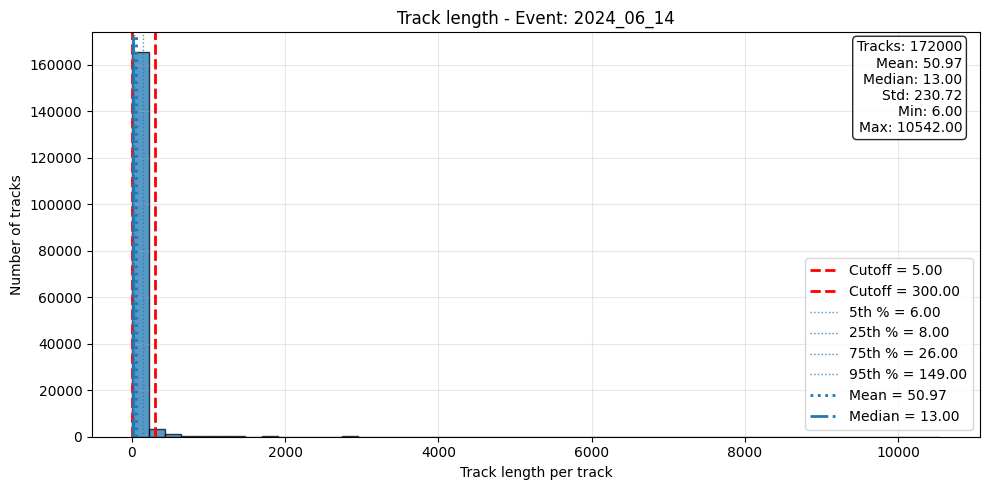

In [7]:
# RAW DATA
df = df_raw
# Filtered DATA
#df = df_filtered_01


track_stats = df.groupby('track').agg(
        track_length=('track', 'size'),
        track_vel_std=('velocity', 'std'),
        track_vel_median=('velocity', 'median'))

n_nan = track_stats['track_length'].isna().sum()
print(f"Excluded tracks due to NaNs: {n_nan}")

values = track_stats['track_length'].dropna()
total_tracks = len(values)

# Statistics
mean_val = np.mean(values)
median_val = np.median(values)
std_val = np.std(values)
min_val = np.min(values)
max_val = np.max(values)

p5, p25, p75, p95 = np.percentile(values, [5, 25, 75, 95])

plt.figure(figsize=(10, 5))

# Histogram
plt.hist(values, bins=50,alpha=0.75,edgecolor='black')

# Cutoff line
plt.axvline(min_track_length,linestyle="--",linewidth=2,label=f"Cutoff = {min_track_length:.2f}",color="red")
plt.axvline(max_track_length,linestyle="--",linewidth=2,label=f"Cutoff = {max_track_length:.2f}",color="red")



plt.axvline(p5,  linestyle=":", linewidth=1, alpha=0.8, label=f"5th % = {p5:.2f}")
plt.axvline(p25, linestyle=":", linewidth=1, alpha=0.8, label=f"25th % = {p25:.2f}")
plt.axvline(p75, linestyle=":", linewidth=1, alpha=0.8, label=f"75th % = {p75:.2f}")
plt.axvline(p95, linestyle=":", linewidth=1, alpha=0.8, label=f"95th % = {p95:.2f}")

# Optional: mean / median lines
plt.axvline(mean_val, linestyle=":", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")

# Labels
plt.xlabel("Track length per track")
plt.ylabel("Number of tracks")
plt.title(f"Track length - Event: {event}")

# Stats text box (inside histogram)
stats_text = (
    f"Tracks: {total_tracks}\n"
    f"Mean: {mean_val:.2f}\n"
    f"Median: {median_val:.2f}\n"
    f"Std: {std_val:.2f}\n"
    f"Min: {min_val:.2f}\n"
    f"Max: {max_val:.2f}"
)

plt.text(
    0.98, 0.98,
    stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    va='top',
    ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()


fig_name = f"track_length_histogram.jpeg"
output_path = Path(output_dir) / fig_name
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

### Track STD Velocity

Excluded tracks due to NaNs: 0


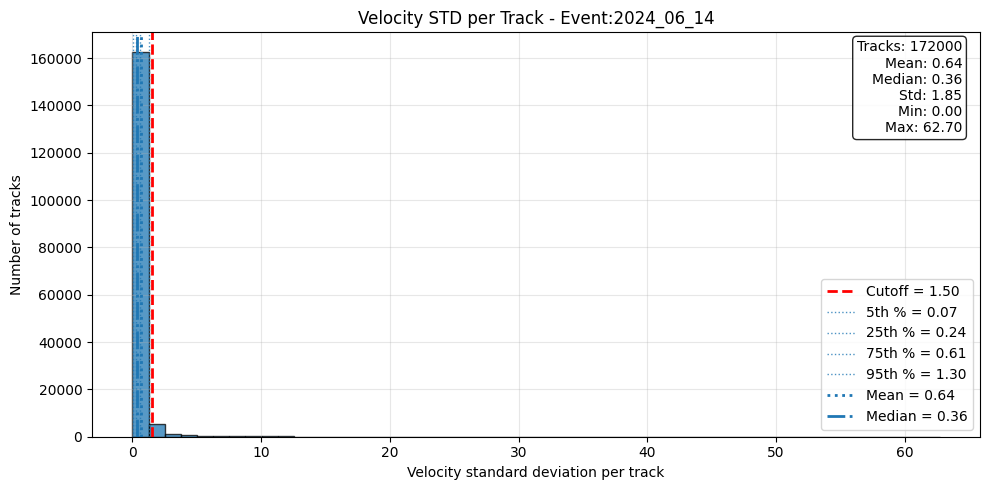

In [8]:
# RAW DATA
# df = df_raw
# Filtered DATA
# df = df_filtered_01


track_stats = df.groupby('track').agg(
        track_length=('track', 'size'),
        track_vel_std=('velocity', 'std'),
        track_vel_median=('velocity', 'median'))

n_nan = track_stats['track_vel_std'].isna().sum()
print(f"Excluded tracks due to NaNs: {n_nan}")

values = track_stats['track_vel_std'].dropna()
total_tracks = len(values)

# Statistics
mean_val = np.mean(values)
median_val = np.median(values)
std_val = np.std(values)
min_val = np.min(values)
max_val = np.max(values)

p5, p25, p75, p95 = np.percentile(values, [5, 25, 75, 95])

plt.figure(figsize=(10, 5))

# Histogram
plt.hist(
    values,
    bins=50,
    alpha=0.75,
    edgecolor='black'
)

# Cutoff line
plt.axvline(
    max_std_track_vel,
    linestyle="--",
    linewidth=2,
    label=f"Cutoff = {max_std_track_vel:.2f}",
    color="red"
)

plt.axvline(p5,  linestyle=":", linewidth=1, alpha=0.8, label=f"5th % = {p5:.2f}")
plt.axvline(p25, linestyle=":", linewidth=1, alpha=0.8, label=f"25th % = {p25:.2f}")
plt.axvline(p75, linestyle=":", linewidth=1, alpha=0.8, label=f"75th % = {p75:.2f}")
plt.axvline(p95, linestyle=":", linewidth=1, alpha=0.8, label=f"95th % = {p95:.2f}")

# Optional: mean / median lines
plt.axvline(mean_val, linestyle=":", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")

# Labels
plt.xlabel("Velocity standard deviation per track")
plt.ylabel("Number of tracks")
plt.title(f"Velocity STD per Track - Event:{event}")

# Stats text box (inside histogram)
stats_text = (
    f"Tracks: {total_tracks}\n"
    f"Mean: {mean_val:.2f}\n"
    f"Median: {median_val:.2f}\n"
    f"Std: {std_val:.2f}\n"
    f"Min: {min_val:.2f}\n"
    f"Max: {max_val:.2f}"
)

plt.text(
    0.98, 0.98,
    stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    va='top',
    ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

fig_name = f"velocity_std_histogram.jpeg"
output_path = Path(output_dir) / fig_name
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

### Min median Track Velocity

Excluded tracks due to NaNs: 0


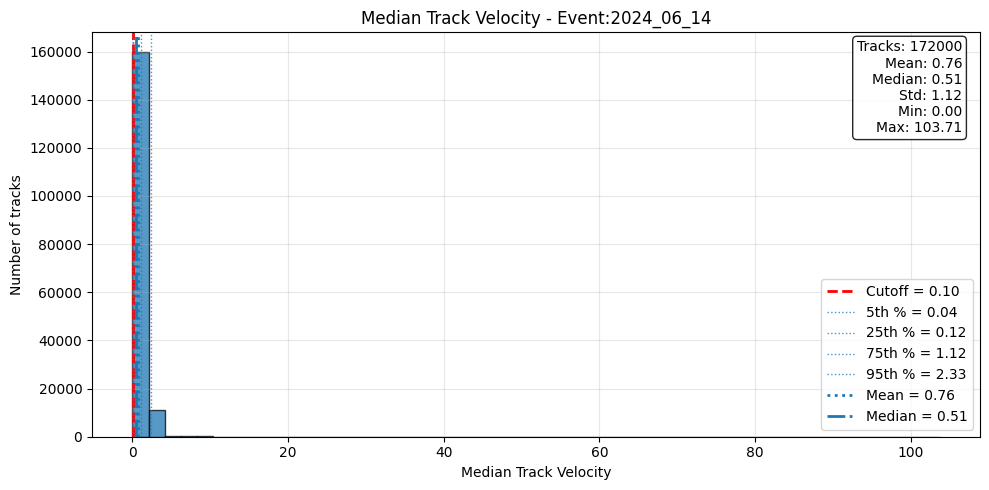

In [9]:
# RAW DATA
#df = df_raw
# Filtered DATA
# df = df_filtered_01


track_stats = df.groupby('track').agg(
        track_length=('track', 'size'),
        track_vel_std=('velocity', 'std'),
        track_vel_median=('velocity', 'median'))

n_nan = track_stats['track_vel_median'].isna().sum()
print(f"Excluded tracks due to NaNs: {n_nan}")

values = track_stats['track_vel_median'].dropna()
total_tracks = len(values)

# Statistics
mean_val = np.mean(values)
median_val = np.median(values)
std_val = np.std(values)
min_val = np.min(values)
max_val = np.max(values)

p5, p25, p75, p95 = np.percentile(values, [5, 25, 75, 95])

plt.figure(figsize=(10, 5))

# Histogram
plt.hist(
    values,
    bins=50,
    alpha=0.75,
    edgecolor='black'
)

# Cutoff line
plt.axvline(
    min_median_track_vel,
    linestyle="--",
    linewidth=2,
    label=f"Cutoff = {min_median_track_vel:.2f}",
    color="red"
)

plt.axvline(p5,  linestyle=":", linewidth=1, alpha=0.8, label=f"5th % = {p5:.2f}")
plt.axvline(p25, linestyle=":", linewidth=1, alpha=0.8, label=f"25th % = {p25:.2f}")
plt.axvline(p75, linestyle=":", linewidth=1, alpha=0.8, label=f"75th % = {p75:.2f}")
plt.axvline(p95, linestyle=":", linewidth=1, alpha=0.8, label=f"95th % = {p95:.2f}")

# Optional: mean / median lines
plt.axvline(mean_val, linestyle=":", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")

# Labels
plt.xlabel("Median Track Velocity")
plt.ylabel("Number of tracks")
plt.title(f"Median Track Velocity - Event:{event}")

# Stats text box (inside histogram)
stats_text = (
    f"Tracks: {total_tracks}\n"
    f"Mean: {mean_val:.2f}\n"
    f"Median: {median_val:.2f}\n"
    f"Std: {std_val:.2f}\n"
    f"Min: {min_val:.2f}\n"
    f"Max: {max_val:.2f}"
)

plt.text(
    0.98, 0.98,
    stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    va='top',
    ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

fig_name = f"track_velocity_histogram.jpeg"
output_path = Path(output_dir) / fig_name
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

### Jump Dist   

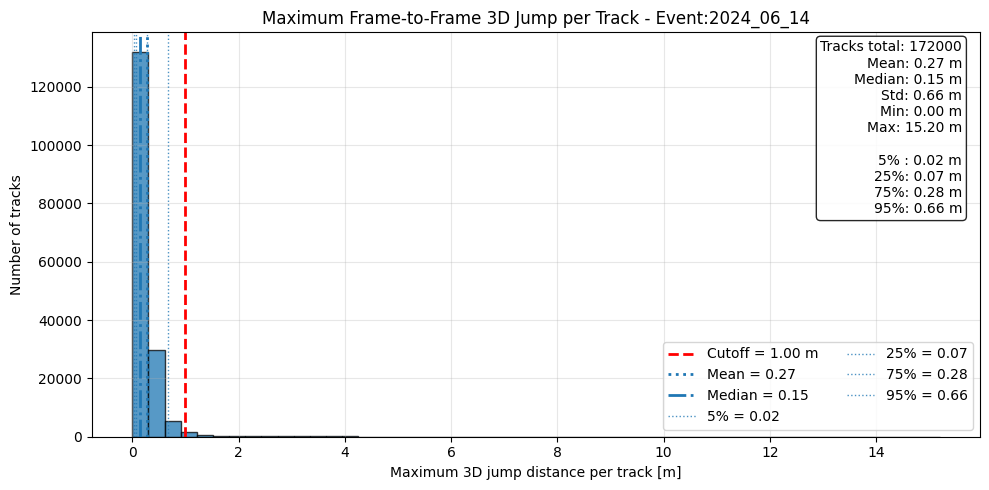

In [10]:
# Filtered DATA
#df = df_filtered_01
# RAW DATA
#df = df_raw
#df = df_filtered_01


df = df.sort_values(['track', 'frame'])

# --- Compute per-frame displacement ---
dx = df.groupby("track")["bb_center_lidar_x"].diff()
dy = df.groupby("track")["bb_center_lidar_y"].diff()
dz = df.groupby("track")["bb_center_lidar_z"].diff()

# --- 3D Euclidean distance ---
df["jump_dist"] = np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)

# --- Identify which tracks have ANY bad jump ---
track_max_jump = df.groupby('track')["jump_dist"].max()

values = track_max_jump.dropna()
total_tracks = len(track_max_jump)
valid_tracks = len(values)
n_nan = total_tracks - valid_tracks

# Statistics
mean_val   = np.mean(values)
median_val = np.median(values)
std_val    = np.std(values)
min_val    = np.min(values)
max_val    = np.max(values)

# Percentiles
p5, p25, p75, p95 = np.percentile(values, [5, 25, 75, 95])

plt.figure(figsize=(10, 5))

# Histogram
plt.hist(values,bins=50,alpha=0.75,edgecolor='black')

# Optional cutoff line (if you have one)
plt.axvline(jump_threshold, linestyle="--", linewidth=2,
            label=f"Cutoff = {jump_threshold:.2f} m",color="red")

# Stats lines
plt.axvline(mean_val, linestyle=":", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")

plt.axvline(p5,  linestyle=":", linewidth=1, alpha=0.8, label=f"5% = {p5:.2f}")
plt.axvline(p25, linestyle=":", linewidth=1, alpha=0.8, label=f"25% = {p25:.2f}")
plt.axvline(p75, linestyle=":", linewidth=1, alpha=0.8, label=f"75% = {p75:.2f}")
plt.axvline(p95, linestyle=":", linewidth=1, alpha=0.8, label=f"95% = {p95:.2f}")

# Labels
plt.xlabel("Maximum 3D jump distance per track [m]")
plt.ylabel("Number of tracks")
plt.title(f"Maximum Frame-to-Frame 3D Jump per Track - Event:{event}")

# Text box
stats_text = (
    f"Tracks total: {total_tracks}\n"
    f"Mean: {mean_val:.2f} m\n"
    f"Median: {median_val:.2f} m\n"
    f"Std: {std_val:.2f} m\n"
    f"Min: {min_val:.2f} m\n"
    f"Max: {max_val:.2f} m\n\n"
    f"5% : {p5:.2f} m\n"
    f"25%: {p25:.2f} m\n"
    f"75%: {p75:.2f} m\n"
    f"95%: {p95:.2f} m"
)

plt.text(
    0.98, 0.98,
    stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    va='top',
    ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)

plt.legend(ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()

fig_name = f"track_jump_histogram.jpeg"
output_path = Path(output_dir) / fig_name
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

## Y Axis Movement

In [ ]:
# Filtered DATA
#df = df_filtered_02
# RAW DATA
#df = df_raw
#df = df_filtered_04

yaxis_movements = []

for track_id, track_df in df.groupby('track'):
    track_df = track_df.sort_values('frame')  # ensure correct order

    n = len(track_df)

    if n < 5:
        continue
    elif n < 1:  # too short, just use first and last
        y_start = track_df['bb_center_lidar_y'].iloc[2]
        y_end = track_df['bb_center_lidar_y'].iloc[-2]
    elif n < 1:  # too short, just use first and last
        y_start = track_df['bb_center_lidar_y'].iloc[4]
        y_end = track_df['bb_center_lidar_y'].iloc[-4]
    elif n <1:  # use second and second-last points
        y_start = track_df['bb_center_lidar_y'].iloc[6]
        y_end = track_df['bb_center_lidar_y'].iloc[-6] #last frames often show jumping
    else:  # use second and second-last points
        y_start = track_df['bb_center_lidar_y'].iloc[2]
        y_end = track_df['bb_center_lidar_y'].iloc[-2]

    yaxis_mov = abs(y_end - y_start)
    yaxis_movements.append(yaxis_mov)

yaxis_movements = np.array(yaxis_movements)

y_mov_values = yaxis_movements
total_tracks = len(y_mov_values)

# statistics
mean_val   = np.mean(y_mov_values)
median_val = np.median(y_mov_values)
std_val    = np.std(y_mov_values)
p5, p25, p75, p95 = np.percentile(y_mov_values, [5, 25, 75, 95])

plt.figure(figsize=(10, 5))

plt.hist(y_mov_values,bins=50,alpha=0.75,edgecolor='black')

# lines
plt.axvline(yaxis_min_length, linestyle="--", linewidth=2,
            label=f"Cutoff = {yaxis_min_length:.2f} m", color="red")

plt.axvline(mean_val, linestyle=":", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")

plt.axvline(p5,  linestyle=":", linewidth=1, alpha=0.8, label=f"5% = {p5:.2f}")
plt.axvline(p25, linestyle=":", linewidth=1, alpha=0.8, label=f"25% = {p25:.2f}")
plt.axvline(p75, linestyle=":", linewidth=1, alpha=0.8, label=f"75% = {p75:.2f}")
plt.axvline(p95, linestyle=":", linewidth=1, alpha=0.8, label=f"95% = {p95:.2f}")

plt.xlabel("Absolute Y-axis movement per track [m]")
plt.ylabel("Number of tracks")
plt.title(f"Total Y-axis Movement per Track")

# text box
stats_text = (
    f"Tracks: {total_tracks}\n"
    f"Mean: {mean_val:.2f}\n"
    f"Median: {median_val:.2f}\n"
    f"Std: {std_val:.2f}\n\n"
    f"5% : {p5:.2f}\n"
    f"25%: {p25:.2f}\n"
    f"75%: {p75:.2f}\n"
    f"95%: {p95:.2f}"
)

plt.text(
    0.98, 0.98,
    stats_text,
    transform=plt.gca().transAxes,
    va="top",
    ha="right",
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.85),
)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

fig_name = f"track_y_movement_histogram.jpeg"
output_path = Path(output_dir) / fig_name
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()


 # Filter Data

In [ ]:

# --- Filter TRACKS
df_filtered_01 = filter_tracks(df_raw, min_track_length=min_track_length, max_track_length=max_track_length,
                                  max_std_track_vel=max_std_track_vel, min_median_track_vel=min_median_track_vel)


In [ ]:
# --- Remove Tracks that jump
df_filtered_02, df_bad = filter_tracks_that_jump(df_filtered_01, jump_threshold= jump_threshold,return_bad=True)


In [ ]:

# --- Remove Tracks that stay stationary or move less than yaxis_min_length
df_filtered_03 = filter_tracks_by_movement(df_filtered_02, yaxis_min_length=yaxis_min_length)

In [ ]:
# Only keep nonzero Velocity-rows
df_filtered_04 = filter_rows_nonzero_velocity(df_filtered_03)



df_clean = df_filtered_04
n_tracks = df_clean['track'].nunique()
n_tracks_raw = df_raw['track'].nunique()
print(f"\nFiltering summary:\n"
    f"  Remaining track IDs: {n_tracks}\n"
    f"  Removed track IDS: {n_tracks_raw - n_tracks}\n"
    f"  Total tracks IDs:     {n_tracks_raw}")




In [ ]:
df_clean = df_filtered_04

In [ ]:
# Compute per-frame statistics and keep only essential cols
df_stats = compute_mean_median_per_frame(df_clean)

# save CSV of STATS after Filtering
#df_stats.to_csv(output_dir / f"df_stats_{event}.csv")

# Prepare dataframe for plotting (moving averages)
df_mova = prepare_df_for_plot(df_stats, window_size=9)
# clean frames with very low number of detections

df_mova = clean_frames_low_detections(df_mova, min_num_detections = 5)

# save CSV of MOVA (plot table)
#df_mova.to_csv(output_dir / f"df_mova_{event}.csv")






Stats per Track

In [ ]:
def compute_track_velocities(
    df_filtered: pd.DataFrame,
    columns: list = None,
    ) -> pd.DataFrame:

    if columns is None:
        columns = ['frame', 'track', 'velocity', 'time']

    # Reduce size by keeping only essential columns
    df = df_filtered[columns].copy()

    mean_vel = (
        df.groupby("track")["velocity"]
          .mean()
          .rename("mean_track_velocity")
    )

    median_vel = (
        df.groupby("track")["velocity"]
          .median()
          .rename("median_track_velocity")
    )

    # 2) Center frame per track
    # index within each track
    idx = df.groupby("track").cumcount()
    sizes = df.groupby("track")["frame"].transform("size")
    center_mask = idx == (sizes  // 2)

    center_frame = (
        df.loc[center_mask, ["track", "frame"]]
          .set_index("track")["frame"]
          .rename("center_frame")
    )

    # 3) Combine
    result = (
        pd.concat([center_frame, mean_vel, median_vel], axis=1)
          .reset_index()
          .sort_values("center_frame")
    )

    return result



In [11]:
frame_quantiles = (
    df_x.groupby("center_frame")["mean_velocity"]
          .quantile([0.25, 0.5, 0.75])
          .unstack()          # columns: 0.25, 0.5, 0.75
          .sort_index()
)

NameError: name 'df_x' is not defined

In [ ]:

plt.figure(figsize=(21,7))

# Scatter: individual tracks
plt.scatter(df_x["center_frame"], df_x["mean_velocity"], marker = '.', alpha = 0.8)

# Moving quantile lines
plt.plot(frame_quantiles.index, frame_quantiles[0.25], linestyle="-", label="25% quantile", color="brown")
plt.plot(frame_quantiles.index, frame_quantiles[0.50], linestyle="-",  label="50% quantile (median)", color="orange", alpha=0.5)
plt.plot(frame_quantiles.index, frame_quantiles[0.75], linestyle="-", label="75% quantile", color="black")

plt.plot(df_mova['frame'], df_mova['mean_velocity_per_frame'], color = 'lightgrey')
plt.plot(df_mova['frame'], df_mova['mean_vel_ma'], color = 'green')

plt.ylim(0,5)
plt.xlabel("Frame")
plt.ylabel("Mean velocity")
plt.title("Moving Quantiles of Mean Track Velocity")
plt.legend()
plt.show()

In [ ]:
df_piv = load_piv_data(event=event)
df_piv_mova = merge_piv_and_tracking(df_piv, df_mova)

In [ ]:
df_track_velocities = compute_track_velocities(df_clean)

df = df_track_velocities

# Set default frame limits if not provided
if start_frame is None:
    start_frame = df['frame'].min()
if end_frame is None:
    end_frame = df['frame'].max()


# --- Frame -> time mapping for top axis ---
frame_to_time = {}
if df_time is not None and not df_time.empty:
    # assume df_time is already cleaned and sorted
    frame_to_time = dict(zip(df_time['frame'], df_time['time']))

# --- Function to convert frame -> MM:SS ---
def frame_to_mmss(frame):
    if not frame_to_time:
        return ""
    nearest_frame = min(frame_to_time.keys(), key=lambda f: abs(f - frame))
    seconds = frame_to_time[nearest_frame]
    if pd.isna(seconds):
        return ""
    minutes = int(seconds) // 60
    secs = int(seconds) % 60
    return f"{minutes:02d}:{secs:02d}"


# --- Start plotting
fig, ax = plt.subplots(figsize=fig_size)

# Raw values
ax.scatter(
    df['center_frame'],
    df['mean_track_velocity'],
    label=f"Mean track velocity",
    color="gray",
    alpha=0.9,
    marker='.'
)

ax.plot(
    df_mova['frame'],
    df_mova['mean_velocity_per_frame'],
    label='Mean velocity per frame',
    linewidth=1,
    alpha=0.9
)

ax.plot(
    df_mova['frame'],
    df_mova['mean_vel_ma'],
    label='Moving average of mean velocity per frame',
    linewidth=2
)

ax.plot(df_piv_mova['mova_frame'],
        df_piv_mova['piv_vel_smoothed'],
        color='goldenrod',
        linewidth=1.75,
        label="Smoothed PIV Velocity")

# --- X axis
ax.set_xlabel("Frame Number", fontsize=16)
#ax.set_xlim(start_frame, end_frame)
ax.set_xlim(0, 100000)

# --- Y axis
ax.set_ylabel('Velocity (m/s)', fontsize=16)
ax.set_ylim(0,5) # Y-axis max * 1.1 to increase dist

ax.tick_params(axis='both', labelsize=15, pad=8, length=4, width=1)
ax.grid(True, linestyle="-", alpha=0.5)

# --- TOP axis (time in MM:SS)
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xlabel("Time [MM:SS]", fontsize=16)


# Set tick locations and formatting
ax_top.xaxis.set_major_locator(ticker.AutoLocator())
ax_top.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: frame_to_mmss(val)))
ax_top.tick_params(axis='x', labelsize=15, pad=8, length=4, width=1)


# Legend
#leg = ax.legend(frameon=True, fontsize=16, loc="best", facecolor="white", edgecolor="black")
#plt.setp(leg.get_lines()[0], alpha=1, linewidth=2)

fig.tight_layout()

# Save figure
#fig_name = f"{statistic.capitalize()}_{plot_variable}_per_frame.jpeg"
#output_path = Path(output_dir) / fig_name
#plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
#  --- MEAN Plots
#  Plot velocity
plot_variable_against_frame(
    df_mova =df_mova,
    plot_variable="velocity",
    statistic="mean",
    color_ma= "Steelblue",
    label_name= 'velocity',
    y_label= 'Velocity (m/s)',
    y_lim= ylim_velocity,
    output_dir=output_dir,
    start_frame=start_frame,
    end_frame=end_frame,
    df_time = df_time,
    fig_size= fig_size
)

# Plot grainsize
plot_variable_against_frame(
    df_mova =df_mova,
    plot_variable="grainsize",
    statistic="mean",
    color_ma="darkorange",
    label_name='grain size',
    y_label= 'Grain size (m)',
    y_lim=ylim_grainsize,
    output_dir=output_dir,
    start_frame=start_frame,
    end_frame=end_frame,
    df_time=df_time,
    fig_size= fig_size
)

# Plot tracks
plot_variable_against_frame(
    df_mova =df_mova,
    plot_variable="tracks",
    statistic="mean",  # statistic is ignored for tracks
    color_ma="red",
    label_name='number of boulder detections',
    y_label='Number of Detections',
    y_lim=(0, df_mova['unique_tracks_per_frame'].max() * 1.1),
    output_dir=output_dir,
    start_frame=start_frame,
    end_frame=end_frame,
    df_time=df_time,
    fig_size=fig_size
)



print('\n === finished :) === \n')





# Combine with PIV DATA

In [ ]:
df_piv = load_piv_data(event=event)
df_piv_mova = merge_piv_and_tracking(df_piv, df_mova)

In [ ]:
plot_piv_and_tracking_velocity(df_piv_mova, event=event, start_frame=start_frame,
                                   end_frame=end_frame, output_dir=output_dir, fig_size=fig_size)


LOWESS

In [8]:
from statsmodels.nonparametric.smoothers_lowess import lowess


In [9]:
df_clean = pd.read_parquet(output_dir / f"df_clean_{event}.parquet")
df_mova = pd.read_parquet(output_dir / f"df_mova_{event}.parquet")
df_piv_mova = pd.read_parquet(output_dir / f"df_piv_mova_{event}.parquet")
df_track_velocities = pd.read_parquet(output_dir / f"df_track_velocities_{event}.parquet")
df_track_velocities_stats = pd.read_parquet(output_dir / f"df_track_velocities_stats_{event}.parquet")

In [37]:
columns = ['frame', 'track', 'velocity', 'time']

# Reduce size by keeping only essential columns
df = df_clean[columns].copy()

mean_track_velocity = (
    df.groupby("track")["velocity"]
      .mean()
      .rename('mean_track_velocity')
)

median_track_velocity = (
    df.groupby("track")["velocity"]
      .median()
      .rename('median_track_velocity')
)

# 2) Center frame per track
# index within each track
idx = df.groupby("track").cumcount()
sizes = df.groupby("track")["frame"].transform("size")
center_mask = idx == (sizes  // 2)

center_frame = (
    df.loc[center_mask, ["track", "frame"]]
      .set_index("track")["frame"]
      .rename("center_frame")
)

# 3) Combine
result = (
    pd.concat([center_frame, mean_track_velocity, median_track_velocity], axis=1)
      .reset_index()
      .sort_values("center_frame")
)

x = result["center_frame"].to_numpy()
y = result["mean_track_velocity"].to_numpy()

frame_window = 20
n_frame =df_clean['frame'].nunique()
fraction =  frame_window /n_frame


smoothed = lowess(
    y,
    x,
    frac=fraction,  #
    it=0,  # use it=1 if you want robust (outlier-resistant)
    return_sorted=True
)

x_s, y_s = smoothed.T
# Create a new DataFrame with smoothed results
df_lowess = pd.DataFrame({
    "center_frame": x_s,
    "smoothed_mean_velocity": y_s
})

# Optional: inspect the first few rows
df_lowess = df_lowess.drop_duplicates(subset="center_frame", keep="first")


In [39]:
fraction
n_frame

16965

In [41]:
df_clean['frame'].nunique()


16965

In [24]:
smoothed.T

array([[7.96300000e+03, 8.02500000e+03, 8.09400000e+03, ...,
        9.77540000e+04, 9.77660000e+04, 9.78620000e+04],
       [7.13917527e-01, 7.30824474e-01, 7.47186317e-01, ...,
        6.92657714e-01, 6.92532142e-01, 6.91600861e-01]], shape=(2, 58204))

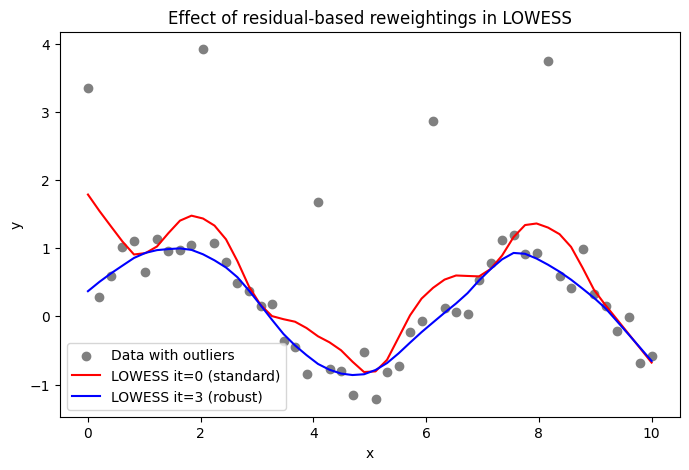

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# Simulated data
np.random.seed(0)
x = np.linspace(0, 10, 50)
y = np.sin(x) + 0.2 * np.random.randn(50)

# Add outliers
y[::10] += 3  # every 10th point is a big outlier

# Standard LOWESS (it=0)
smoothed_standard = lowess(y, x, frac=0.2, it=0)
x_std, y_std = smoothed_standard.T

# Robust LOWESS (it=3)
smoothed_robust = lowess(y, x, frac=0.2, it=3)
x_rob, y_rob = smoothed_robust.T

# Plot
plt.figure(figsize=(8,5))
plt.scatter(x, y, color='gray', label='Data with outliers')
plt.plot(x_std, y_std, color='red', label='LOWESS it=0 (standard)')
plt.plot(x_rob, y_rob, color='blue', label='LOWESS it=3 (robust)')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Effect of residual-based reweightings in LOWESS")
plt.show()